In [1]:
import json
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import os
import random
import numpy as np

# 0. Leemos los datos

In [2]:
def read_json(path):
    with open(path) as f:
        data = json.load(f)
    return data

def leer_k_archivos_json(k):
    archivos_json = [archivo for archivo in os.listdir("data") if archivo.endswith('.json')]
    random.seed(42)
    paths = random.choices(archivos_json, k=k)

    all_playlists = []
    for p in paths:
        data = read_json(f"data\{p}")
        playlist = pd.DataFrame(data['playlists'])
        all_playlists.append(playlist)

    playlists = pd.concat(all_playlists, ignore_index=True)
    return playlists

In [3]:
# Leer 10 archivos json osea 10000 playlists
playlists = leer_k_archivos_json(10)
playlists.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,random,false,674000,1479168000,141,117,1,"[{'pos': 0, 'artist_name': 'R.E.M.', 'track_ur...",26,36307284,81,NaN
1,Summer 2015,false,674001,1471564800,191,155,1,"[{'pos': 0, 'artist_name': 'Kanye West', 'trac...",88,42162338,131,NaN
2,Dinner,false,674002,1501027200,26,24,1,"[{'pos': 0, 'artist_name': 'Dean Martin', 'tra...",2,6041217,21,NaN
3,Reggae,false,674003,1474156800,26,25,2,"[{'pos': 0, 'artist_name': 'Sizzla', 'track_ur...",4,5572231,16,NaN
4,angst,false,674004,1506902400,22,21,1,"[{'pos': 0, 'artist_name': 'Death Cab for Cuti...",5,5383303,19,NaN


In [4]:
playlists.isna().sum()

name                0
collaborative       0
pid                 0
modified_at         0
num_tracks          0
num_albums          0
num_followers       0
tracks              0
num_edits           0
duration_ms         0
num_artists         0
description      9821
dtype: int64

In [5]:
playlists["description"][~playlists["description"].isna()]

105                            it was a long ass semester
123           intertwining your soul with somebody else ✨
161            for all of your &quot;non-Hype&quot; moods
208         free lil kodak they dont like to see u wining
233     theese are all the song i recomend wile workin...
                              ...                        
9815                      my remix&#x2F;dance music phase
9870                                no description needed
9900    some very mainstream and basic music to dance ...
9927                           some good stuff right here
9939         Old school music (stuff that mom and I like)
Name: description, Length: 179, dtype: object

In [6]:
def expandir_tracks(playli):
    expanded_tracks_df = pd.DataFrame()

    # Iterar sobre cada fila y expandir los datos JSON en un dataframe
    for _, row in playli.iterrows():
        # Cargar el JSON desde la columna 'tracks'
        tracks = row['tracks']

        # Comprobar si 'tracks' es una cadena que necesita ser convertida de JSON
        if isinstance(tracks, str):
            try:
                tracks = json.loads(tracks)  # Cargar la cadena JSON
            except json.JSONDecodeError:
                tracks = []  # En caso de error, usar una lista vacía
        elif not isinstance(tracks, list):
            tracks = []  # Asegurar que tracks sea una lista si no es una cadena

        if tracks:
            track_data = json_normalize(tracks)
            track_data['pid'] = row['pid']  # añadimos el id de la playlist para mantener la referencia
            expanded_tracks_df = pd.concat([expanded_tracks_df, track_data], ignore_index=True)
    return expanded_tracks_df

In [7]:
expanded_tracks_df = expandir_tracks(playlists)

In [8]:
playlists.drop("tracks", axis=1, inplace=True)
playlists.head()

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description
0,random,false,674000,1479168000,141,117,1,26,36307284,81,NaN
1,Summer 2015,false,674001,1471564800,191,155,1,88,42162338,131,NaN
2,Dinner,false,674002,1501027200,26,24,1,2,6041217,21,NaN
3,Reggae,false,674003,1474156800,26,25,2,4,5572231,16,NaN
4,angst,false,674004,1506902400,22,21,1,5,5383303,19,NaN


In [9]:
by_playlist = expanded_tracks_df.groupby('pid').agg(
    num_songs=('track_name', 'count'),  # Contamos el número de canciones por playlist
    avg_duration=('duration_ms', 'mean'),  # Calculamos la duración media de las canciones
    artists=('artist_name', lambda x: set(x)),  # Obtenemos un conjunto de artistas únicos
    songs =('track_uri', lambda x: set(x)),  # Obtenemos un conjunto de caciones únicas
    albums =('album_name', lambda x: set(x))  # Obtenemos un conjunto de albumes únicos
)

by_playlist['avg_duration'] = by_playlist['avg_duration'] / 60000 # Convertimos la duración de milisegundos a minutos
# by_playlist.head()

In [10]:
playlist_per_song = expanded_tracks_df.groupby('track_uri')['pid'].agg(list).reset_index()
# playlist_per_song.head()

- Pasamos los URL a un id de cancion

In [11]:
url_id = {}
n = 1

def key_exists(key, dictionary):
    try:
        value = dictionary[key]
        return True
    except KeyError:
        return False

def get_id(x, n):
    if not key_exists(x, url_id):
        url_id[x] = n
        n += 1
    return url_id[x], n

values = []

for val in playlist_per_song["track_uri"]:
    valu, n = get_id(val, n)
    values.append(valu)

playlist_per_song["track_id"] = values
playlist_per_song.head()

,track_uri,pid,track_id
0,spotify:track:000pmJ2wC4EvNSbXa3aHwT,[176550],1
1,spotify:track:000xQL6tZNLJzIrtIgxqSl,"[674120, 674982, 120045, 120092, 120110, 12019...",2
2,spotify:track:000xYdQfIZ4pDmBGzQalKU,[674480],3
3,spotify:track:0010mZpCCwlPwoBiBsjoac,"[120352, 761127, 124129]",4
4,spotify:track:001BVhvaZTf2icV88rU3DA,"[346171, 707721, 478347]",5


In [12]:
expanded_tracks_df["track_id"] = expanded_tracks_df["track_uri"].apply(lambda x: url_id[x])

In [13]:
by_playlist["track_id"] = by_playlist["songs"].apply(lambda x: [url_id[val] for val in list(x)])
# by_playlist.head()

In [14]:
playlist_per_song['n_playlists'] = playlist_per_song['pid'].apply(lambda x: len(set(x)))

In [15]:
playlist_per_song["n_playlists"].mean()

3.839445982096328

In [16]:
cancion_mas_reproducida = playlist_per_song["n_playlists"].idxmax()
playlist_per_song.iloc[cancion_mas_reproducida]

track_uri                   spotify:track:1xznGGDReH1oQq0xzbwXa3
pid            [674001, 674041, 674050, 674058, 674069, 67407...
track_id                                                   43755
n_playlists                                                  442
Name: 43754, dtype: object

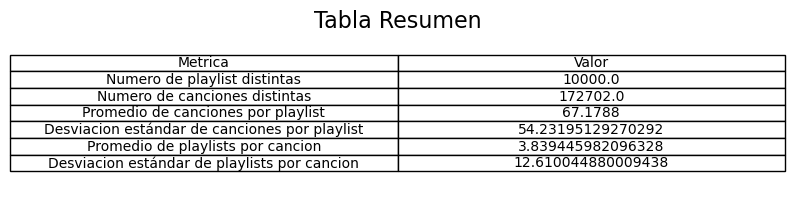

In [19]:
metricas = {
    'Metrica': ['Numero de playlist distintas', 'Numero de canciones distintas',
                'Promedio de canciones por playlist', 'Desviacion estándar de canciones por playlist',
                'Promedio de playlists por cancion', 'Desviacion estándar de playlists por cancion'],
    'Valor': [by_playlist.shape[0], len(expanded_tracks_df["track_uri"].unique()), by_playlist["num_songs"].mean(), by_playlist["num_songs"].std(),
              playlist_per_song["n_playlists"].mean(), playlist_per_song["n_playlists"].std()]
}

df = pd.DataFrame(metricas)

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
tabla = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colWidths=[0.5, 0.5])
plt.title('Tabla Resumen', fontsize=16)
plt.show()

# 2. Baseline

In [17]:
!pip3 install implicit
# clear_outputs()

In [18]:
import implicit as implicit

c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import mean_average_precision_at_k, ndcg_at_k

In [21]:
#Hay playlist que tienen la misma cancion más de una vez, aca las tratamos solo una vez
playlist_track = expanded_tracks_df[["pid","track_id","track_name","duration_ms","artist_name"]].drop_duplicates()
# playlist_track.head()

- Separamos en data de validación y data de entrenamiento

In [22]:
# Acá separamos en las playlists con un número de canciones mayor a NUM_CANCIONES
# Luego nos quedamos solo con las playlist con un número mayor para hacer el entrenamiento y el testeo
NUM_CANCIONES = 10
song_per_playlist = playlist_track.groupby('pid')['track_id'].agg(list).reset_index()
song_per_playlist['n_songs'] = song_per_playlist['track_id'].apply(len)
pid_less = song_per_playlist[song_per_playlist['n_songs'] < NUM_CANCIONES]['pid'].unique()
pid_more = song_per_playlist[song_per_playlist['n_songs'] >= NUM_CANCIONES]['pid'].unique()
print(len(pid_less), len(pid_more))

352 9648


In [24]:
from sklearn.model_selection import train_test_split

In [25]:
# Acá hacemos una separación de las playlists que le vamos a entregar la información completa,
# y las que le vamos a entregar solo las primeras n

train_pid, test_pid = train_test_split(pid_more, test_size=0.2, random_state=42)
print(len(train_pid), len(test_pid))

7718 1930


In [26]:
song_per_playlist.drop("n_songs", axis=1, inplace=True)
song_per_playlist.head(3)

,pid,track_id
0,3000,"[64915, 122329, 18296, 163225, 80436, 146959, ..."
1,3001,"[136703, 156726, 48512, 30344, 103200, 156821,..."
2,3002,"[155266, 63130, 124133, 36885, 14275, 115421, ..."


In [39]:
def Sep_first_n(n, pids):
    #Primero separamos las primeras n canciones de una playlist y las siguientes
    all = song_per_playlist[song_per_playlist['pid'].isin(pids)].copy()
    all.loc[:, 'fist_5'] = all['track_id'].apply(lambda x: x[:n])
    all.loc[:, 'next']= all['track_id'].apply(lambda x: x[n:])
    all.drop("track_id", axis=1, inplace=True)
    #Luego utilizamos las primeras n canciones para entrenar y las siguientes para testear
    train = all[['pid', 'fist_5']].explode('fist_5')
    test = all[['pid', 'next']].explode('next')
    train.rename(columns={'fist_5': 'track_id'}, inplace=True)
    test.rename(columns={'next': 'track_id'}, inplace=True)
    return train, test

In [45]:
# Acá separamos para las playlist que están en test sus primeras PRIMERAS_N canciones para train y el resto para train
# Hay que asegurarse que PRIMERAS_N << NUM_CANCIONES

PRIMERAS_N = 5
test_train, test_test = Sep_first_n(PRIMERAS_N, test_pid)

# clear_outputs()

In [46]:
# Luego acá creamos los datasets de train y test

data = playlist_track[['pid', 'track_id']]
train_data = data[data['pid'].isin(train_pid)]                       # Playlists con todas las canciones
train_data = pd.concat([train_data, test_train], ignore_index=True)  # Playlists con solo las PRIMERAS_N canciones
test_data = test_test


In [47]:
# Pequeño test para revisar cuantas canciones el modelo no se ha entrenado con, lo cual implica que no las va a poder recomendar
# Este número debería bajar si incluimos más data en el comienzo

test_tracks_ids = test_data['track_id'].unique()
train_tracks_ids = train_data['track_id'].unique()
tracks_not_in_train = np.setdiff1d(test_tracks_ids, train_tracks_ids)
tracks_not_in_train, len(tracks_not_in_train) / len(test_tracks_ids)


(array([13, 18, 23, ..., 172678, 172679, 172693], dtype=object),
 0.39359153166684546)

# New ALS

In [48]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [49]:
# Create user-item interaction matrices for train and test sets
train_interaction_matrix = csr_matrix((np.ones(len(train_data)), (train_data['pid'], train_data['track_id'])))
test_interaction_matrix = csr_matrix((np.ones(len(test_data)), (test_data['pid'], test_data['track_id'])))


model = AlternatingLeastSquares(factors=100, alpha = 20)
model.fit(train_interaction_matrix)

c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: Intel MKL BLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues
  check_blas_config()
100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


In [141]:
test_test

,pid,track_id
0,3000,146959
0,3000,63793
0,3000,66369
0,3000,78526
0,3000,20469
...,...,...
9998,901998,70517
9998,901998,84648
9998,901998,135777
9998,901998,115900


In [161]:
def R_precision(recommended, actual):
    n = len(actual)
    recommended = recommended[:n]
    in_both = np.intersect1d(recommended, actual)
    return len(in_both) / n

def dcg(relevance_scores):
    return relevance_scores[0] + np.sum(
        [rel / np.log2(idx + 1) for idx, rel in enumerate(relevance_scores[1:], start=2)]
    )

def ndcg(recommended, actual):
    """Calculate Normalized Discounted Cumulative Gain (NDCG) at k"""
    # Relevance scores: 1 if the item is in the ground truth, 0 otherwise
    relevance_scores = [1 if item in actual else 0 for item in recommended]

    # Calculate DCG for the recommended list
    DCG = dcg(relevance_scores)

    # Calculate IDCG for the ideal list (the best possible ranking)
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)
    IDCG = dcg(ideal_relevance_scores)

    # Calculate NDCG
    NDCG = DCG / IDCG if IDCG > 0 else 0
    return NDCG

def rec_song_clicks(recommended, actual):
    for i, item in enumerate(recommended):
        if item in actual:
            clicks = np.floor(i / 10)
            return clicks
    return 51

In [162]:
# Pequeño código mostrando que el modelo efectivamente logra recomendar canciones relevantes para usuarios (playlists) del train
# Falta implementar las métricas, las clásicas de ndcg y r-precision y las que se crearon para la competencia

user_ids = test_pid
print(len(user_ids))
print(train_data['track_id'].nunique())
r_prec = []
ndcgs = []
clicks = []
for userid in user_ids:

  ids, scores = model.recommend(userid, train_interaction_matrix[userid], N=500, filter_already_liked_items=True)
  # print(ids, scores)
  actual = test_test[test_test['pid'] == userid]['track_id'].values
  # print(actual)

  r_prec.append(R_precision(ids, actual))
  ndcgs.append(ndcg(ids, actual))
  clicks.append(rec_song_clicks(ids, actual))

  # in_both = np.intersect1d(ids, actual)
  # if in_both.size > 0:
  #   print("Usuario: ", userid)
  #   print(in_both)

print(f"R prec: {np.mean(r_prec)}, NDCG: {np.mean(ndcgs)}, Clicks: {np.mean(clicks)}")

1930
150136
0.11770926313960363
0.45538328246017357
5.1953367875647665


In [137]:
expanded_tracks_df[expanded_tracks_df["pid"] == 761194][["artist_name","track_name","track_id"]].drop_duplicates()

,artist_name,track_name,track_id
283624,A Great Big World,Say Something,121463
283625,Ed Sheeran,Photograph,147960
283626,Sam Smith,I'm Not The Only One,15146
283627,Passenger,Let Her Go - Acoustic,159782
283628,Katy Perry,The One That Got Away - Acoustic,127277
283629,Adele,Someone Like You,105445
283630,Sam Smith,Stay With Me,115647
283631,Selena Gomez,The Heart Wants What It Wants,168866
283632,Selena Gomez & The Scene,A Year Without Rain,17225
283633,Harry Styles,Sign of the Times,119602


In [116]:
expanded_tracks_df[expanded_tracks_df["track_id"].isin([35447,78792,105445,115647,119602,150026,168866,171052])][["artist_name","track_uri","track_name","track_id"]].drop_duplicates()

,artist_name,track_uri,track_name,track_id
1691,Adele,spotify:track:4kflIGfjdZJW4ot2ioixTB,Someone Like You,105445
2764,Sam Smith,spotify:track:5Db9VIdDsN5yu3Eu7CT0i4,Stay With Me,115647
3263,Alex & Sierra,spotify:track:1almCHdsfikRPfVB9VrEdT,Little Do You Know,35447
3548,Selena Gomez,spotify:track:7pJgjBf82BrUQ3z7HdQvW1,The Heart Wants What It Wants,168866
3569,Christina Perri,spotify:track:6lanRgr6wXibZr8KgzXxBl,A Thousand Years,150026
5838,gnash,spotify:track:7vRriwrloYVaoAe3a9wJHe,"i hate u, i love u (feat. olivia o'brien)",171052
7750,Harry Styles,spotify:track:5Ohxk2dO5COHF1krpoPigN,Sign of the Times,119602
15382,Enrique Iglesias,spotify:track:3Y8WRvVlQHMvtBwaV4TGlJ,Hero,78792


# Old User User

Este lo voy a cambiar considerando el nuevo train test split y haciendolo más legible

(yo creo que con el nuevo train test split voy a poder hacerlo mucho más rapido (y entendible) pq con el anterior no sabía que hacer con playlists con las cuales no se había entrenado)

In [108]:
user_factors = model.user_factors
item_factors = model.item_factors

# Define a function to find similar users using cosine similarity
def find_similar_users(user_id, user_factors, num_users=10):
    user_vector = user_factors[user_id].reshape(1, -1)
    similarities = cosine_similarity(user_vector, user_factors).flatten()
    similar_users = np.argsort(similarities)[::-1][1:num_users+1]  # Skip the user itself
    return similar_users

# Define a function to infer new user vector
def infer_new_user_vector(new_user_tracks, item_factors, model):
    new_user_vector = np.zeros(model.factors)
    for track_id in new_user_tracks:
        new_user_vector += model.item_factors[track_id]
    new_user_vector /= len(new_user_tracks)  # Average the vectors
    return new_user_vector

# Define a function to calculate NDCG@10
def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size == 0:
        return 0.0
    dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
    idcg = np.sum(np.ones_like(r) / np.log2(np.arange(2, r.size + 2)))
    return dcg / idcg

# Evaluate the recommendations on the test set using NDCG@10
def evaluate_ndcg(test_data, user_factors, item_factors, model, num_users=10, k=10):
    ndcg_scores = []
    for user_id in test_data['pid'].unique():
        test_items = test_data[test_data['pid'] == user_id]['track_id'].values
        if user_id in train_data['pid'].unique():  # Existing user
            similar_users = find_similar_users(user_id, user_factors, num_users)
            recommended_items = train_data[train_data['pid'].isin(similar_users)]['track_id'].unique()
            # print('entra acá')
        else:  # New user
            # print('es considerado nuevo user')
            new_user_tracks = test_data[test_data['pid'] == user_id]['track_id'].values
            new_user_vector = infer_new_user_vector(new_user_tracks, item_factors, model)
            similarities = cosine_similarity(new_user_vector.reshape(1, -1), item_factors).flatten()
            recommended_items = np.argsort(similarities)[::-1][:k]

        relevance = np.isin(recommended_items, test_items).astype(int)
        ndcg_score = ndcg_at_k(relevance, k)
        ndcg_scores.append(ndcg_score)

    return np.mean(ndcg_scores)

# Compute and print the NDCG@10 score
ndcg_score = evaluate_ndcg(test_data, user_factors, item_factors, model)
print(f"NDCG@10: {ndcg_score:.4f}")

NDCG@10: 0.0000


# New Item Item

In [165]:
item_model = implicit.nearest_neighbours.CosineRecommender(K=500)
item_model.fit(train_interaction_matrix)

c:\Users\jasar\anaconda3\envs\Recomendadores\lib\site-packages\implicit\utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007997989654541016 seconds
  warnings.warn(
100%|██████████| 172703/172703 [00:02<00:00, 70005.20it/s]


In [167]:
user_ids = test_pid
print(len(user_ids))
print(train_data['track_id'].nunique())
r_prec = []
ndcgs = []
clicks = []
for userid in user_ids:

  ids, scores = item_model.recommend(userid, train_interaction_matrix[userid], N=500, filter_already_liked_items=True)
  actual = test_test[test_test['pid'] == userid]['track_id'].values

  r_prec.append(R_precision(ids, actual))
  ndcgs.append(ndcg(ids, actual))
  clicks.append(rec_song_clicks(ids, actual))


print(f"R prec: {np.mean(r_prec)}, NDCG: {np.mean(ndcgs)}, Clicks: {np.mean(clicks)}")

1930
150136
R prec: 0.07381722969578625, NDCG: 0.3503277264858729, Clicks: 12.468911917098445


## Transformers4Rec

In [170]:
!pip install transformers4rec

  Using cached transformers4rec-23.12.0.tar.gz (1.1 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached transformers-4.30.2-py3-none-any.whl.metadata (113 kB)
  Using cached pyarrow-16.1.0-cp38-cp38-win_amd64.whl.metadata (3.1 kB)
  Using cached torchmetrics-1.4.0.post0-py3-none-any.whl.metadata (19 kB)
  Using cached merlin-models-23.12.0.tar.gz (485 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached 

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.


In [185]:
from transformers4rec import torch as tr
import torch
from transformers4rec.config.trainer import T4RecTrainingArguments
from transformers4rec.torch import Trainer

In [196]:
train_data.iloc[:, 1]

0          79272
1          62591
2         158219
3         165661
4          88163
           ...  
535732    147289
535733     85203
535734     63166
535735    157310
535736    159258
Name: track_id, Length: 535737, dtype: object

In [214]:
print(len(train_data["pid"].unique()))

ids = random.choices(train_data["pid"].unique(), k=10)
sample = train_data[train_data["pid"].isin(ids)]

In [215]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()


users = user_encoder.fit_transform(sample.iloc[:, 0])  
items = item_encoder.fit_transform(sample.iloc[:, 1]) 

In [216]:
num_users = len(np.unique(users))
num_items = len(np.unique(items))
interactions = np.zeros((num_users, num_items))

for u, i in zip(users, items):
    user, item = int(u), int(i)
    interactions[user, item] = 1

In [217]:
interactions_tensor = torch.tensor(interactions, dtype=torch.float32)

In [219]:
from torch.utils.data import TensorDataset, DataLoader

In [220]:
dataset = TensorDataset(interactions_tensor)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [221]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [238]:
schema = tr.data.tabular_sequence_testing_data.schema
max_sequence_length, d_model = 20, 64

input_module = tr.TabularSequenceFeatures.from_schema(
    schema,
    max_sequence_length=max_sequence_length,
    continuous_projection=d_model,
    aggregation="concat",
    masking="causal",
)

prediction_tasks = tr.NextItemPredictionTask()

transformer_config = tr.XLNetConfig.build(
    d_model=d_model,
    n_head=4,
    n_layer=2,
    total_seq_length=max_sequence_length
)

model = transformer_config.to_torch_model(input_module, prediction_tasks)
model = model.to(device)

In [233]:
for batch in dataloader:
    inputs = batch[0].to(device)
    print(inputs)
    model(inputs)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]])


AttributeError: 'Tensor' object has no attribute 'items'

In [230]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss()  # Suponiendo clasificación binaria para la interacción

# Función de entrenamiento
def train_model(model, dataloader, optimizer, loss_fn, epochs=5):
    model.train()  # Modo de entrenamiento
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            # Asignar datos a la GPU si está disponible
            inputs = batch[0].to(device)  # Assuming 'inputs' is the first item in the batch
            
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = inputs  # Aquí asumimos que los labels son los mismos que los inputs, aunque esto puede necesitar revisión
            loss = loss_fn(outputs, labels)  # Asegurarse de que los labels también estén en el dispositivo correcto
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}')

# Entrenar el modelo
train_model(model, dataloader, optimizer, loss_fn)

AttributeError: 'Tensor' object has no attribute 'items'

In [ ]:
training_args = T4RecTrainingArguments(
            output_dir="./tmp",
            num_train_epochs=3,
            fp16=True,
        )

recsys_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataloader=train_loader,
    eval_dataloader=eval_loader,
)

recsys_trainer.train()

In [182]:
schema = tr.Schema().from_json('squema.json')
max_sequence_length, d_model = 20, 64

# Configurar el módulo de entrada
input_module = tr.TabularSequenceFeatures.from_schema(
    schema,
    max_sequence_length=max_sequence_length,
    continuous_projection=d_model,
    aggregation="concat",
    masking="causal"
)

prediction_tasks = tr.NextItemPredictionTask()
transformer_config = tr.XLNetConfig.build(
    d_model=d_model,
    n_head=4,
    n_layer=2,
    total_seq_length=max_sequence_length
)
model = transformer_config.to_torch_model(input_module, prediction_tasks)

KeyError: 'continuous_module'